In [20]:
# Package Imports - feel free to add what you think might be useful! 
# %pip install requests
import requests

## Task 3: Quest for Quantum Randomness

### Part A: Truly Different

First 10 quantum random numbers: [138, 69, 23, 20, 251, 38, 68, 24, 230, 102]
Shannon Entropy: 3.1219 bits (max 8.0 for uniform 8-bit values)
Min-Entropy: 2.3219 bits


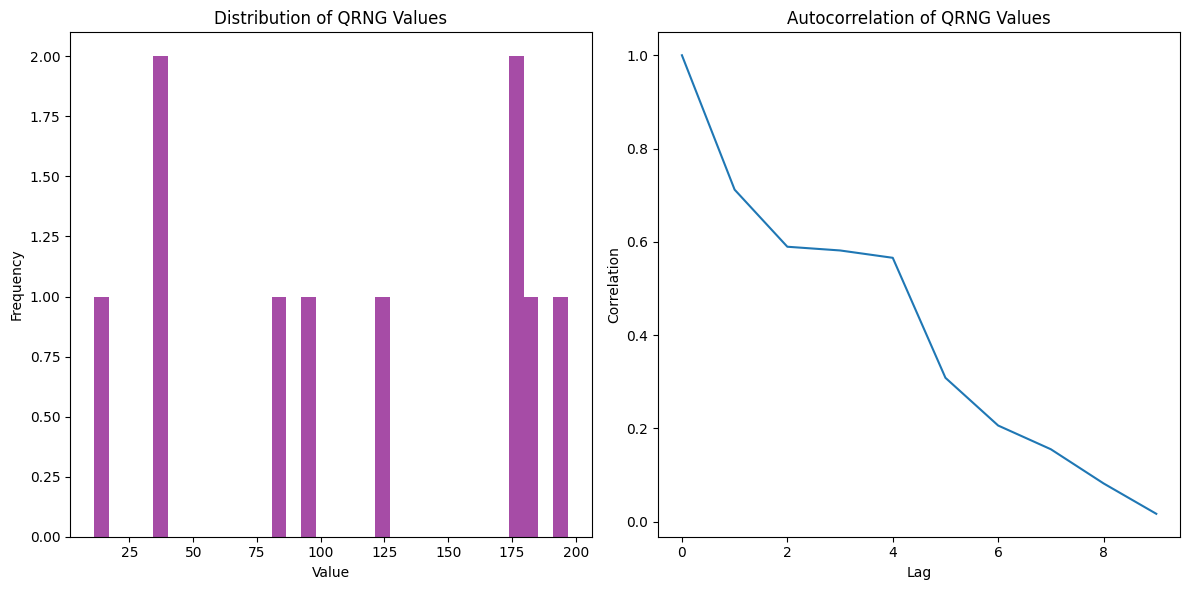

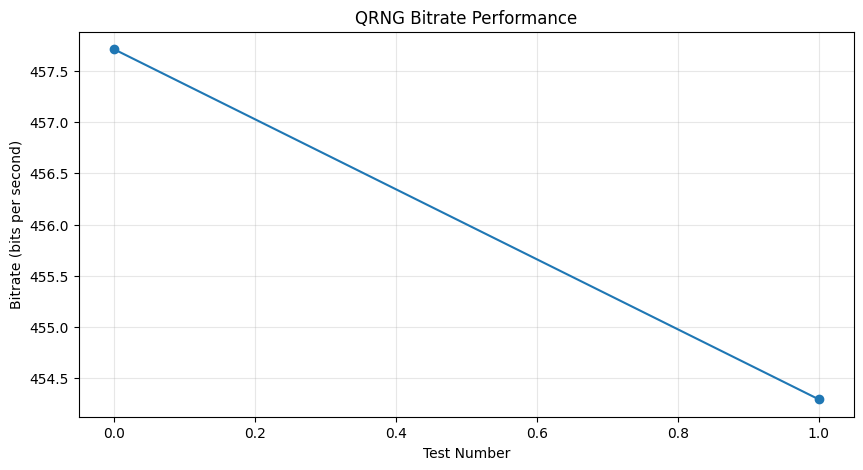

Average bitrate: 456.00 bits/sec


456.0029155129902

In [19]:
""" 
Using the QRNGaaS User Manual provided, 
write Python code to get random numbers from IDQuantique's Quantum Random Number Generators. 

The API documentation is available at: https://drive.google.com/file/d/1OkyRUP7HC4dbmi8OvoT4EuvXqRVGdsjD/view
You'll probably reuse this code for Task 4. So write it well!

If you are unfamiliar with writing HTTP requests in Python, 
https://www.w3schools.com/python/module_requests.asp

If you're really stuck, this can definitely help. Though we encourage you to read the documentation yourself! 
https://curlconverter.com/python/
"""

import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import hashlib

class QRNGaaS:
    def __init__(self, api_key="aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI"):
        self.api_key = api_key
        self.base_url = "https://qrng.idqloud.com/api/1.0/"
        self.bitrate_history = []
    
    def get_random_numbers(self, num=1, min_val=0, max_val=255, data_type="uint8"):
        """Get random numbers from QRNGaaS API"""
        endpoint = "short" if num <= 100 else "int"
        url = f"{self.base_url}{endpoint}"
        
        params = {
            "min": min_val,
            "max": max_val,
            "quantity": num,
            "type": data_type
        }
        
        headers = {
            "X-API-KEY": self.api_key
        }
        
        try:
            start_time = time.time()
            response = requests.get(url, params=params, headers=headers)
            response.raise_for_status()
            elapsed = time.time() - start_time
            
            # Calculate bitrate (bits per second)
            bits_per_num = (max_val - min_val + 1).bit_length()
            total_bits = num * bits_per_num
            bitrate = total_bits / elapsed if elapsed > 0 else 0
            self.bitrate_history.append(bitrate)
            # print(response.json())
            return response.json()['data']
        except requests.exceptions.RequestException as e:
            print(f"Error fetching random numbers: {e}")
            return None
    
    def get_random_bytes(self, num_bytes=32):
        """Get random bytes from QRNGaaS"""
        nums_needed = (num_bytes + 1) // 2  # Since we get uint16 numbers (2 bytes each)
        numbers = self.get_random_numbers(num=nums_needed, min_val=0, max_val=65535, data_type="uint16")
        print(numbers)
        if numbers is None:
            return None
        
        # Convert numbers to bytes
        result = bytearray()
        for num in numbers:
            result.extend(num.to_bytes(2, byteorder='big'))
        
        return bytes(result[:num_bytes])
    
    def analyze_entropy(self, num_samples=1000):
        """Analyze entropy of QRNG output"""
        samples = self.get_random_numbers(num=num_samples, min_val=0, max_val=255)
        
        if samples is None:
            return None
        
        # Calculate Shannon entropy
        counts = np.bincount(samples, minlength=256)
        probs = counts / num_samples
        probs = probs[probs > 0]  # Avoid log(0)
        shannon_entropy = -np.sum(probs * np.log2(probs))
        
        # Calculate min-entropy
        max_prob = np.max(counts) / num_samples
        min_entropy = -np.log2(max_prob)
        
        print(f"Shannon Entropy: {shannon_entropy:.4f} bits (max 8.0 for uniform 8-bit values)")
        print(f"Min-Entropy: {min_entropy:.4f} bits")
        
        # Plot distribution
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(samples, bins=32, color='purple', alpha=0.7)
        plt.title('Distribution of QRNG Values')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        
        # Plot autocorrelation
        plt.subplot(1, 2, 2)
        autocorr = np.correlate(samples, samples, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        plt.plot(autocorr[:50])
        plt.title('Autocorrelation of QRNG Values')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        
        plt.tight_layout()
        plt.show()
        
        return samples
    
    def plot_bitrate(self, num_tests=10, num_per_test=1000):
        """Plot bitrate performance over multiple tests"""
        if not self.bitrate_history:
            for _ in range(num_tests):
                self.get_random_numbers(num=num_per_test)
        
        plt.figure(figsize=(10, 5))
        plt.plot(self.bitrate_history, 'o-')
        plt.title('QRNG Bitrate Performance')
        plt.xlabel('Test Number')
        plt.ylabel('Bitrate (bits per second)')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        avg_bitrate = np.mean(self.bitrate_history)
        print(f"Average bitrate: {avg_bitrate:.2f} bits/sec")
        return avg_bitrate

# Example usage
qrng = QRNGaaS()

# Get 10 random numbers between 0 and 255
random_numbers = qrng.get_random_numbers(num=10)
print(f"First 10 quantum random numbers: {random_numbers}")

# Get 32 random bytes
# random_bytes = qrng.get_random_bytes(10)
# print(f"Random bytes (hex): {random_bytes}")

# Analyze entropy
qrng.analyze_entropy(10)

# Plot bitrate performance
qrng.plot_bitrate()

In [8]:
"""
To get started, we provide a simple example of how to use the API to generate 10 int16 random numbers.
In particular, observe where we pass in the min and max parameters to specify the range of random numbers we want
and the quantity parameter to specify how many random numbers we want.
Here is the API KEY you will need to use: aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI
"""

!curl "https://qrng.idqloud.com/api/1.0/short?max=32767&min=-32768&quantity=10" -X GET -H "X-API-KEY:aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI"

{"data":[-12999,-21322,-22848,10462,-13676,-12452,30871,28638,-30925,21319],"dataType":"int16"}

### Part B: Easy as Pi!

In [33]:
from tqdm import tqdm


Estimating π with Quantum RNG...


100%|██████████| 10000/10000 [48:07<00:00,  3.46it/s]  


Estimate: 3.26920000
Error: 0.12760735
Time: 2887.70 seconds


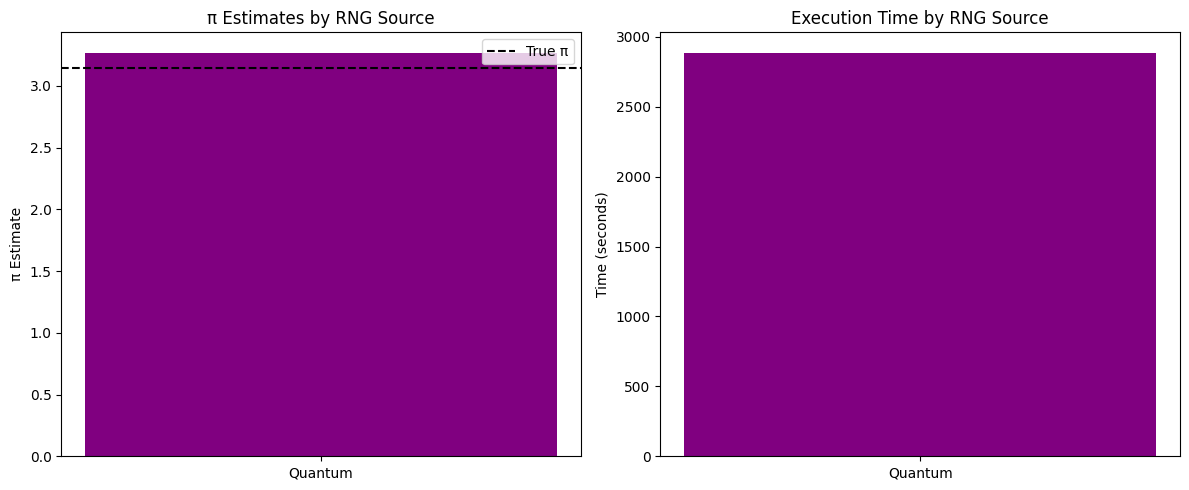

In [34]:
"""
Implement the Monte Carlo algorithm for estimating Pi using your various sources of randomness. 

If you are stuck on how to implement the algorithm: 
https://www.geeksforgeeks.org/estimating-value-pi-using-monte-carlo/
"""
def estimate_pi(rng_source, num_points=1000000):
    """Estimate pi using Monte Carlo method with specified RNG source"""
    inside = 0
    
    for _ in tqdm(range(num_points)):
        # Generate random point in [0,1) x [0,1)
        x = rng_source.get_random_numbers(num=1, min_val=0, max_val=99)[0] / 100
        y = rng_source.get_random_numbers(num=1, min_val=0, max_val=99)[0] / 100
        
        # Check if point is inside unit circle
        if x**2 + y**2 <= 1:
            inside += 1
    
    pi_estimate = 4 * inside / num_points
    return pi_estimate

# Compare different RNG sources
def compare_pi_estimates(num_points=1000000):
    """Compare pi estimation across different RNG sources"""
    sources = {
        "Quantum": QRNGaaS(),
        # "Jitter": JitterRNG(),
        # "Audio": MicrophoneRNG(),
        # "Thermal": ThermalRNG()
    }
    
    results = {}
    times = {}
    
    for name, rng in sources.items():
        try:
            print(f"\nEstimating π with {name} RNG...")
            start_time = time.time()
            pi_est = estimate_pi(rng, num_points)
            elapsed = time.time() - start_time
            
            results[name] = pi_est
            times[name] = elapsed
            
            print(f"Estimate: {pi_est:.8f}")
            print(f"Error: {abs(pi_est - np.pi):.8f}")
            print(f"Time: {elapsed:.2f} seconds")
        except Exception as e:
            print(f"Error with {name} RNG: {e}")
            results[name] = None
            times[name] = None
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Pi estimates
    plt.subplot(1, 2, 1)
    valid_results = {k: v for k, v in results.items() if v is not None}
    names = list(valid_results.keys())
    values = list(valid_results.values())
    
    plt.bar(names, values, color=['purple', 'blue', 'green', 'red'])
    plt.axhline(y=np.pi, color='black', linestyle='--', label='True π')
    plt.title('π Estimates by RNG Source')
    plt.ylabel('π Estimate')
    plt.legend()
    
    # Plot 2: Execution times
    plt.subplot(1, 2, 2)
    valid_times = {k: v for k, v in times.items() if v is not None}
    names = list(valid_times.keys())
    values = list(valid_times.values())
    
    plt.bar(names, values, color=['purple', 'blue', 'green', 'red'])
    plt.title('Execution Time by RNG Source')
    plt.ylabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()
    
    return results, times

# Run comparison (this may take a while)
pi_results, pi_times = compare_pi_estimates(10000)